In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [ ]:
import matplotlib
import torch
import argparse
import wandb
from torch.utils.data import DataLoader
from data import datasets
import utils.utils as utils
import plotting
import os
import einops 
import json
from helpers import logging, create
from manifold import Sphere
from sdes import AmbientSphericalBrownianMotion, AmbientSphericalGenerative
from models import ConcatMLP
from einops import rearrange, reduce, repeat

_folder_name_keys = ['dataset', 'batch_size', 'lr', 'num_iterations', 'T0', 'emb_size', 'hidden_layers']


def get_args():
    parser = argparse.ArgumentParser()

    # i/o
    parser.add_argument('--dataset', type=str,
                        choices=['UniformSlice', 'Earthquake', 'Fire', 'Volcano'],
                        default='UniformSlice')
    parser.add_argument('--dataroot', type=str, default='data')
    parser.add_argument('--saveroot', type=str, default='saved')
    parser.add_argument('--expname', type=str, default='sphere')
    parser.add_argument('--print_every', type=int, default=100)
    parser.add_argument('--sample_every', type=int, default=500)
    parser.add_argument('--checkpoint_every', type=int, default=500)
    parser.add_argument('--num_steps', type=int, default=100,
                        help='number of integration steps for sampling')

    # hparam
    parser.add_argument('--T0', type=float, default=2.0,
                        help='integration time')
    parser.add_argument('--emb_size', type=int, default=256,
                        help='num of hiddens')
    parser.add_argument('--hidden_layers', type=int, default=2,
                        help='num of hiddens')

    # optimization
    parser.add_argument('--div', type=str, choices=['deterministic'], )
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--val_batch_size', type=int, default=256)
    parser.add_argument('--test_batch_size', type=int, default=256)
    parser.add_argument('--lr', type=float, default=0.001,
                        help='learning rate')
    parser.add_argument('--num_iterations', type=int, default=10000)

    return parser.parse_args(['--dataset' ,'UniformSlice'])


args = get_args()
folder_tag = 'riemannian-diffusion'
folder_name = '-'.join([str(getattr(args, k)) for k in _folder_name_keys])
create(args.saveroot, folder_tag, args.expname, folder_name)
folder_path = os.path.join(args.saveroot, folder_tag, args.expname, folder_name)
print_ = lambda s: logging(s, folder_path)
print_(f'folder path: {folder_path}')
print_(str(args))
with open(os.path.join(folder_path, 'args.txt'), 'w') as out:
    out.write(json.dumps(args.__dict__, indent=4))

# wandb.init(project="riemannian-diffusion", name=f'{args.expname}-{folder_name}', config=args.__dict__)

if args.dataset == 'UniformSlice':
    trainset = datasets.UniformPatchDataset(n=50000)
    trainloader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=0)

    valset = datasets.UniformPatchDataset(n=10000)
    valloader = DataLoader(trainset, batch_size=args.val_batch_size, shuffle=True, num_workers=0)

    testset = datasets.UniformPatchDataset(n=10000)
    testloader = DataLoader(trainset, batch_size=args.test_batch_size, shuffle=True, num_workers=0)
elif args.dataset == 'Earthquake':
    trainset = datasets.Earthquake()
    trainloader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=0)

    valset = datasets.Earthquake()
    valloader = DataLoader(trainset, batch_size=args.val_batch_size, shuffle=True, num_workers=0)

    testset = datasets.Earthquake()
    testloader = DataLoader(trainset, batch_size=args.test_batch_size, shuffle=True, num_workers=0)
else:
    raise Exception(f'Dataset {args.dataset} not implemented')

a = ConcatMLP(3, 1, args.emb_size, args.hidden_layers)
print_(a)
cuda = torch.cuda.is_available()

if cuda:
    print('cuda available')
    a = a.cuda()
    device = 'cuda'
else:
    print('cuda unavailable')
    device = 'cpu'

sde = AmbientSphericalBrownianMotion(args.T0)
gsde = AmbientSphericalGenerative(utils.get_drift(a, args.T0, Sphere, proj_div_proj=utils.zero_func))
opt = torch.optim.Adam(a.parameters(), lr=args.lr)
count = 0

if os.path.exists(os.path.join(folder_path, 'checkpoint.pt')):
    a, opt, not_finished, count = torch.load(os.path.join(folder_path, 'checkpoint.pt'))
    gsde = AmbientSphericalGenerative(utils.get_drift(a, args.T0, Sphere, proj_div_proj=utils.zero_func))
    pass
else:
    not_finished = True
    count = 0

    a.eval()
#     wandb.log(
#         {'samples': wandb.Image(plotting.plot_scatter3D(gsde.sample(utils.sample_spherical_uniform(n=1024).to(device),
                                                                    args.T0, args.num_steps).detach().cpu().numpy()))},
        step=count)
    a.train()

#     wandb.log({'test data': wandb.Image(plotting.plot_scatter3D(testset.data[:1024]))},
#               step=count)

while not_finished:
    for x in trainloader:
        t = utils.stratified_uniform(x.size(0), args.T0)
        y = sde.sample(x, t).requires_grad_(True)
        if cuda:
            y = y.cuda()
            t = t.cuda()

        loss = - utils.elbo(y, t, a, Sphere.proj2manifold, Sphere.proj2tangent, args.T0, utils.zero_func,
                            utils.zero_func).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        count += 1
#         wandb.log({'loss': loss.item()}, step=count)
        if count % args.print_every == 0 or count == 1:
            print_(f'Iteration {count} \tloss {loss.item()}')

        if count % args.sample_every == 0:
            a.eval()
#             wandb.log(
#                 {'samples': wandb.Image(
#                     plotting.plot_scatter3D(gsde.sample(utils.sample_spherical_uniform(n=1024).to(device),
#                                                         args.T0,
#                                                         args.num_steps).detach().cpu().numpy()))},
#                 step=count)
            a.train()

        if count % args.checkpoint_every == 0:
            torch.save([a, opt, not_finished, count], os.path.join(folder_path, 'checkpoint.pt'))

        if count >= args.num_iterations:
            not_finished = False
            print_('Finished training')
            break

In [2]:
utils.elbo(y, t, a, Sphere.proj2manifold, Sphere.proj2tangent, args.T0, utils.zero_func,
                            utils.zero_func).shape

torch.Size([64])

In [3]:
def exponent_step(y, s, a_func, proj2manifold, proj2tangent, ds, db, proj_div_proj=None, div_proj_div_proj=None):
    py = proj2manifold(y)
    a = a_func(py, s)
    pa = proj2tangent(py, a)
    
    if proj_div_proj is not None:
        pdp = proj_div_proj(py)
    else:
        raise NotImplementedError  # TODO
        
    v0 = pdp + pa

    div_v0 = 0
    for i in range(y.size(1)):
        div_v0 += torch.autograd.grad(v0[:, i].sum(), y, create_graph=False, retain_graph=True)[0][:, i]

    if div_proj_div_proj is not None:
        dpdp = div_proj_div_proj(y)
    else:
        raise NotImplementedError  # TODO
        
    A = (a*db).sum(axis=-1)
    B = (-0.5 * (a ** 2).sum(dim=1) - div_v0 + 0.5 * dpdp)*ds
    
    return  A + B

In [4]:
from sdes import midpoint_step
from utils.utils import LOG_SPHERICAL_UNIFORM

def integrate_elbok(sde, y0, a_func, proj2manifold, proj2tangent, T, K, steps: int = 1000,
          proj_div_proj=None,
          div_proj_div_proj=None):
    
    expos = []
    for _ in range(K):
        y_next = y0
        s = 0
        ds = T / steps
        expo = torch.zeros(y0.shape[0]).to(y0)+LOG_SPHERICAL_UNIFORM
        for _ in range(steps):
            s += ds
            y = y_next.detach().requires_grad_(True)
            y_next, increment = midpoint_step(s, ds, y, sde.f, sde.g_increment, proj2manifold, return_increment=True)
            expo_step = exponent_step(y=y,s=s,a_func=a,
                      proj2manifold=proj2manifold,
                      proj2tangent=proj2tangent, 
                      ds=ds,
                      db=increment, 
                      proj_div_proj=utils.zero_func,
                      div_proj_div_proj=utils.zero_func)
            expo = expo_step.detach() + expo
        expos.append(expo)
        
    #sum different samples 
    expos = torch.stack(expos, axis=1) # [batch_size, K]
    logK = torch.log(torch.tensor(K)).to(x0)
    elbok = torch.logsumexp(expos, dim=1)-logK
    
    return elbok

In [5]:
def integrate_elbok_parallel(sde, y0, a_func, proj2manifold, proj2tangent, T, K, steps: int = 1000,
          proj_div_proj=None,
          div_proj_div_proj=None):
    
    #adding K copies of the data so I can parallelize the sampling
    y0 = repeat(y0, 'b d -> b k d', k=K)
    y0 = rearrange(y0, 'b k d -> (b k) d')
    
    y_next = y0
    s = 0
    ds = T / steps
    expo = torch.zeros(y0.shape[0]).to(y0)+LOG_SPHERICAL_UNIFORM
    for _ in range(steps):
        s += ds
        y = y_next.detach().requires_grad_(True)
        y_next, increment = midpoint_step(s, ds, y, sde.f, sde.g_increment, proj2manifold, return_increment=True)
        expo_step = exponent_step(y=y,s=s,a_func=a,
                  proj2manifold=proj2manifold,
                  proj2tangent=proj2tangent, 
                  ds=ds,
                  db=increment, 
                  proj_div_proj=utils.zero_func,
                  div_proj_div_proj=utils.zero_func)
        expo = expo_step.detach() + expo
    
    expo = rearrange(expo, '(b k) -> b k', k=K)
    logK = torch.log(torch.tensor(K)).to(x0)
    elbok = torch.logsumexp(expo, dim=1)-logK
    
    return elbok

In [7]:
K = 10
steps = 1000
x0 = next(iter(trainloader)) # [batch_size, manifold_dim]

In [8]:
X = x0[0:1].repeat(500, 1)

In [9]:
elbok1 = integrate_elbok(sde, X, a, Sphere.proj2manifold, Sphere.proj2tangent, sde.T, 1, steps=1000)
elbok4 = integrate_elbok(sde, X, a, Sphere.proj2manifold, Sphere.proj2tangent, sde.T, 4, steps=1000)
elbok10 = integrate_elbok(sde, X, a, Sphere.proj2manifold, Sphere.proj2tangent, sde.T, 10, steps=1000)

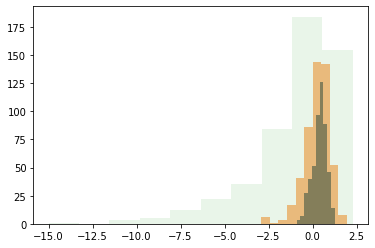

In [17]:
import matplotlib.pyplot as plt
plt.hist(elbok10.detach().numpy(),)
plt.hist(elbok4.detach().numpy(), alpha=0.5)
plt.hist(elbok1.detach().numpy(), alpha=0.1)

plt.show()

In [18]:
elbok1.mean()

tensor(-0.8898)

In [19]:
elbok4.mean()

tensor(0.2383)

In [20]:
elbok10.mean()

tensor(0.3962)